In [1]:
# import the needed functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as pdr

## 1. Basic Statistics

In [159]:
#initiate a dataframe to store the data
df = pd.DataFrame()

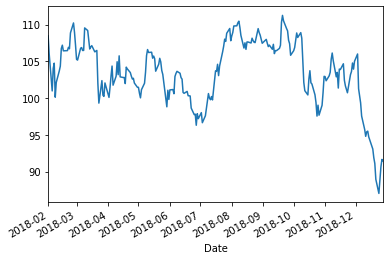

In [160]:
#download JPM's stock price from yahoo
start_date = '2018-02-01'
end_date = '2018-12-30'
source = "yahoo"
JPM = pdr.DataReader('JPM', source, start_date, end_date)
df['JPM'] = JPM.loc['2018-02':,]['Adj Close'] #keep only the adjust close price from 2018-02-01 to 2018-12-30
df['JPM'].plot()

In [161]:
#calculate and print average stock value during the period
JPM_avg = JPM['Adj Close'].mean()
print(JPM_avg)

103.59153389308763


In [162]:
#calculate and print stock volatility
JPM_vol = JPM['Adj Close'].std()
print(JPM_vol)

4.409561753124603


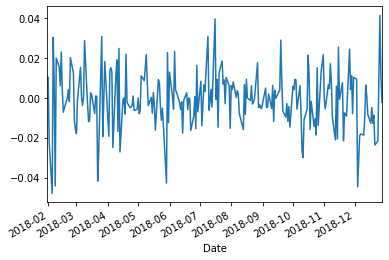

In [163]:
#calculate and print daily return
JPM['daily_return'] = JPM['Adj Close'].pct_change()
JPM['daily_return'].plot()

## 2. Linear Regression

In [164]:
from sklearn.linear_model import LinearRegression

In [165]:
#load S&P500 index
SP500 = pdr.DataReader('^GSPC', source, start_date, end_date)
df['SP500'] = SP500.loc[start_date:,]['Adj Close']

In [166]:
#define comparison plot function
def compare_line(df,column1,column2,label1,label2):
    fig, ax1 = plt.subplots(figsize=(16,5))
    color1 = 'red'
    ax1.plot(df.index, df[column1], label=label1, color=color1)
    ax1.set_ylabel(label1, color=color1)
    ax2 = ax1.twinx()
    color2 = 'blue'
    ax2.plot(df.index, df[column2], label=label2, color=color2)
    ax2.set_ylabel(label2, color=color2)
    plt.show()

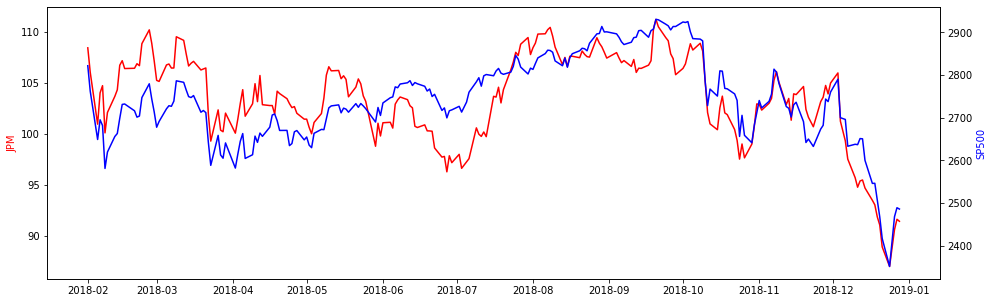

In [167]:
#plot JPM and SP500 price in one chart while using different y-axis
compare_line(df,'JPM','SP500','JPM','SP500')

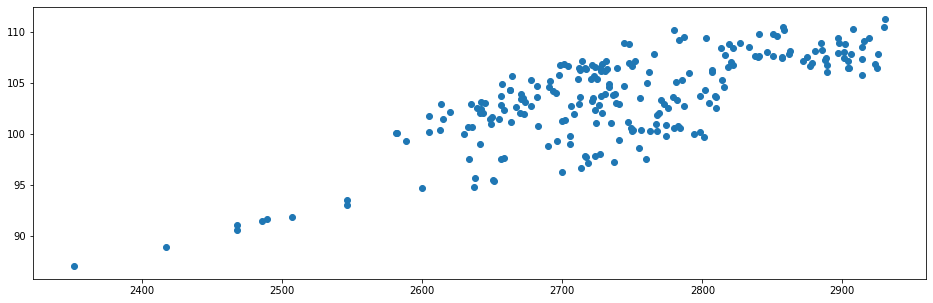

In [168]:
plt.figure(figsize=(16,5))
plt.scatter(df[['SP500']],df[['JPM']])

In [169]:
#initiate linear regression model
#and fit the model with SP500 as dependent variable and JPM as independent variable
reg = LinearRegression()
reg.fit(df[['SP500']],df[['JPM']])
print(reg)
reg.score(df[['SP500']], df[['JPM']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


0.578802722852773

In [170]:
#print the coefficient and intercept
print('Coefficient:{}, Intercept:{}'.format(reg.coef_,reg.intercept_))

Coefficient:[[0.03291303]], Intercept:[13.28603993]


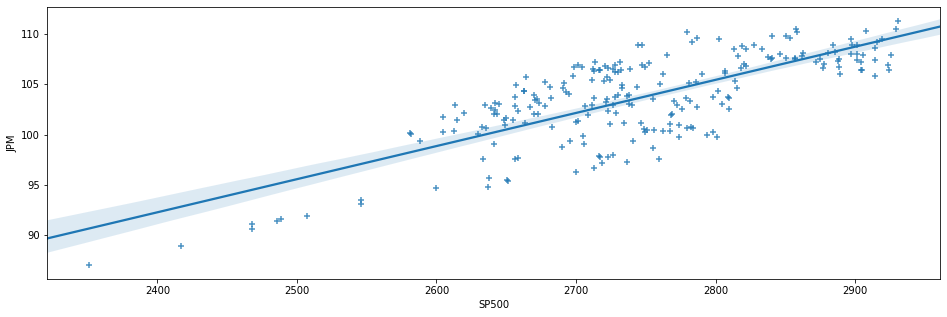

In [171]:
#plot scatter chart for JPM and SP500 price with regression line
plt.figure(figsize=(16,5))
sns.regplot(x='SP500',y='JPM',data=df,marker='+')

In [172]:
reg.score(df[['SP500']],df[['JPM']])

0.578802722852773

## 3. Univariate Time Series

### 3.1 Downloaded the data, ran ADF Test and did diff to make the series stationary.

In [191]:
#load the home price index
data = pd.read_csv("CSUSHPISA.csv",header=0,index_col=['DATE'],parse_dates=True)
data = data.resample('M').first()

In [192]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

In [193]:
#identification:
#1. plot the price
#define plot function
def plot_df(df,df_column,df_label):
    fig, ax1 = plt.subplots(figsize=(16,5))
    color1 = 'blue'
    ax1.plot(df.index, df[df_column], label=df_label, color=color1)
    ax1.set_ylabel(df_label, color=color1)
    plt.show()

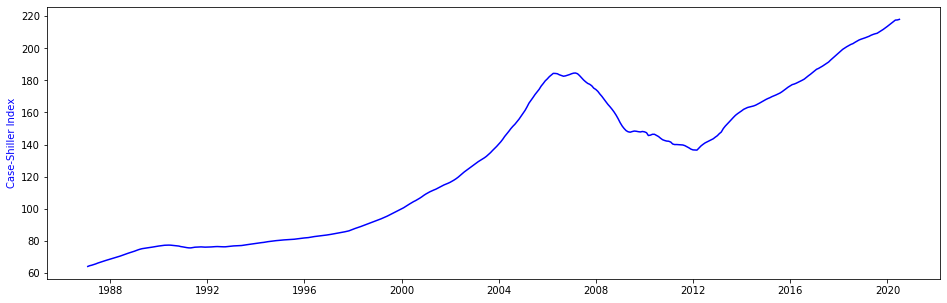

In [194]:
#plot Case-Shiller Index and SP500 price using the function defined - plot_df
plot_df(data,'CSUSHPISA','Case-Shiller Index')

In [195]:
#2. Augmented Dickey-Fuller Test
def adf_test(df_test):
    CSI_adfuller = adfuller(df_test)
    print("Augemented Dickey-Fuller Test Statistics:\n\
***************************************************************************\n\
t-test:{};\n\
p-value:{};\n\
critical test statistics:{}"
          .format(CSI_adfuller[0],CSI_adfuller[1],CSI_adfuller[4]))

In [196]:
adf_test(data['CSUSHPISA'])

Augemented Dickey-Fuller Test Statistics:
***************************************************************************
t-test:-0.438817776819273;
p-value:0.9034130797196386;
critical test statistics:{'1%': -3.447360865754795, '5%': -2.8690374364690445, '10%': -2.5707639493486636}


P-value > 5%, fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary. So diff or log is necessary to make the series stationary. And the diffed series with lag 1 is stationary with p-value =0.049

In [197]:
#take the first order difference and run ADF test again
data_diff = data['CSUSHPISA'].diff().dropna()
adf_test(data_diff)

Augemented Dickey-Fuller Test Statistics:
***************************************************************************
t-test:-2.8681753215515724;
p-value:0.04917591022316217;
critical test statistics:{'1%': -3.447360865754795, '5%': -2.8690374364690445, '10%': -2.5707639493486636}


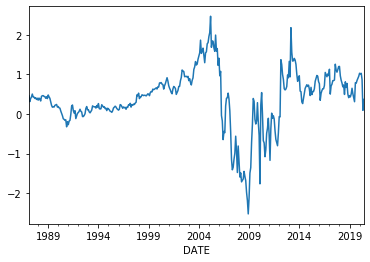

In [198]:
data_diff.plot()

### 3.2 Decide the value of p and q.

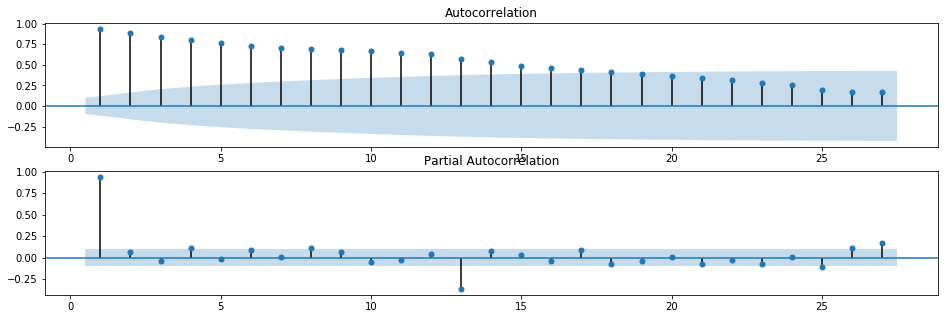

In [199]:
#check acf and pacf plot to see if there's clear pattern of AR and MA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,5))
plot_acf(data_diff, zero=False, ax=ax1)
plot_pacf(data_diff, zero=False, ax=ax2)
plt.show()

The plots indicate p=12, q=0. And we use a grid searching method to find the best p and q. PACF has a spark at lag 1, 13, 25.. So, I think we just not make any conclusion here but jump to the grid search..

In [189]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import arma_order_select_ic
arma_order_select_ic(data_diff, max_ar=13, max_ma=4, ic=['aic', 'bic'])

{'aic':              0           1           2           3           4
 0   890.105542  545.150195  316.284992  234.265746  166.866047
 1    42.310060   43.089580   44.695795   42.483160   44.450189
 2    42.998762   33.047070   35.042037   36.886553   37.505915
 3    44.372249   35.042250   35.745309   36.787158   37.969442
 4    42.069348   36.893598   36.641602   25.699731   27.936736
 5    43.982194   37.803208   37.716459   28.117468   28.136319
 6    42.834360   39.406693   39.550381   26.282875   15.589818
 7    44.813882   40.547112   40.787686   27.456278   16.518525
 8    42.601469   43.948729   16.639633   14.959098   27.339397
 9    43.239544   44.947372   12.972344   14.933742   19.343629
 10   44.438633   34.981882   14.952295    7.481526    8.160414
 11   46.254800   37.273285   14.910800         NaN   13.796436
 12   47.670928   33.001084   13.387788    5.312878    0.253589
 13   -1.299168   -1.013180   -0.143964    0.137937    0.095697,
 'bic':              0          

**Fit the data using ARIMA(13,1,0) model**

In [200]:
from statsmodels.tsa.arima_model import ARIMA

arima_model = ARIMA(data['CSUSHPISA'], order=(13,1,0))
arima_fitted = arima_model.fit()
arima_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.CSUSHPISA   No. Observations:                  401
Model:                ARIMA(13, 1, 0)   Log Likelihood                  15.650
Method:                       css-mle   S.D. of innovations              0.232
Date:                Sun, 27 Sep 2020   AIC                             -1.299
Time:                        17:42:01   BIC                             58.610
Sample:                    02-28-1987   HQIC                            22.423
                         - 06-30-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3888      0.188      2.070      0.039       0.021       0.757
ar.L1.D.CSUSHPISA      0.9000      0.047     19.308      0.000       0.809       0.991
ar.L2.D.CSUSHPISA      0.0561      0.063      0.891      0.373      -0.067       0.180
ar.L3.D.CSUSHPISA     -0.1396      0.063     -2.208      0.028      -0.264      -0.016
ar.L4.D.CSUSHPISA      0.1458      0.063      2.299      0.022       0.022       0.270
ar.L5.D.CSUSHPISA     -0.0696      0.063     -1.097      0.273      -0.194       0.055
ar.L6.D.CSUSHPISA      0.0489      0.063      0.774      0.439      -0.075       0.173
ar.L7.D.CSUSHPISA     -0.0573      0.063     -0.908      0.364      -0.181       0.066
ar.L8.D.CSUSHPISA      0.0142      0.063      0.225      0.822      -0.110       0.138
ar.L9.D.CSUSHPISA      0.1427      0.063      2.263      0.024       0.019       0.266
ar.L10.D.CSUSHPISA    -0.0718      0.063     -1.141      0.255      -0.195       0.052
ar.L11.D.CSUSHPISA    -0.0313      0.063     -0.498      0.619      -0.154       0.092
ar.L12.D.CSUSHPISA     0.3486      0.063      5.549      0.000       0.225       0.472
ar.L13.D.CSUSHPISA    -0.3465      0.047     -7.412      0.000      -0.438      -0.255
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0682           -0.0000j            1.0682           -0.5000
AR.2            -0.9681           -0.5107j            1.0946           -0.4227
AR.3            -0.9681           +0.5107j            1.0946            0.4227
AR.4            -0.5337           -0.9344j            1.0760           -0.3326
AR.5            -0.5337           +0.9344j            1.0760            0.3326
AR.6             0.0342           -1.1003j            1.1009           -0.2451
AR.7             0.0342           +1.1003j            1.1009            0.2451
AR.8             0.5312           -0.9726j            1.1082           -0.1704
AR.9             0.5312           +0.9726j            1.1082            0.1704
AR.10            0.9099           -0.5703j            1.0739           -0.0891
AR.11            0.9099           +0.5703j            1.0739            0.0891
AR.12            1.0636           -0.0589j            1.0652           -0.0088
AR.13            1.0636           +0.0589j            1.0652            0.0088
------------------------------------------------------------------------------
"""

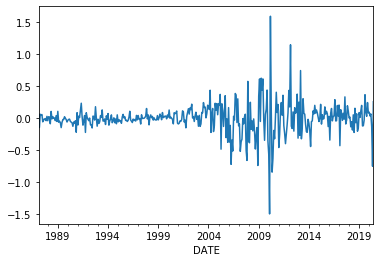

In [90]:
arima_fitted.resid.plot()

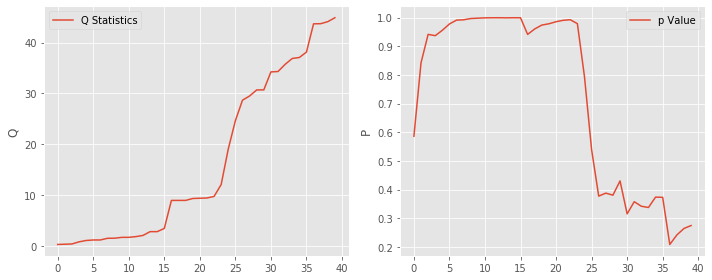

In [94]:
# whitenoise test
def whitenoise_test(ts):
    '''计算box pierce 和 box ljung统计量'''
    from statsmodels.stats.diagnostic import acorr_ljungbox
    q, p = acorr_ljungbox(ts)
    with plt.style.context('ggplot'):
        fig = plt.figure(figsize=(10, 4))
        axes = fig.subplots(1,2)
        axes[0].plot(q, label='Q Statistics')
        axes[0].set_ylabel('Q')

        axes[1].plot(p, label='p Value')
        axes[1].set_ylabel('P')
        
        axes[0].legend()
        axes[1].legend()
        plt.tight_layout()
        return
whitenoise_test(arima_fitted.resid)

**Fit the data using ARIMA(2,1,1)model and analyse the residual**

In [201]:
from statsmodels.tsa.arima_model import ARIMA

arima_model = ARIMA(data['CSUSHPISA'], order=(2,1,1))
arima_fitted = arima_model.fit()
arima_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.CSUSHPISA   No. Observations:                  401
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -11.524
Method:                       css-mle   S.D. of innovations              0.248
Date:                Sun, 27 Sep 2020   AIC                             33.047
Time:                        17:42:18   BIC                             53.017
Sample:                    02-28-1987   HQIC                            40.955
                         - 06-30-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3854      0.196      1.969      0.050       0.002       0.769
ar.L1.D.CSUSHPISA    -0.0468      0.021     -2.201      0.028      -0.089      -0.005
ar.L2.D.CSUSHPISA     0.9274      0.020     46.008      0.000       0.888       0.967
ma.L1.D.CSUSHPISA     0.9581      0.024     39.128      0.000       0.910       1.006
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0135           +0.0000j            1.0135            0.5000
AR.2            1.0640           +0.0000j            1.0640            0.0000
MA.1           -1.0437           +0.0000j            1.0437            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
whitenoise_test(arima_fitted.resid)

Ljung-Box Q-test shows that the p value drops to around zero after lag 12. The residual series shows autocorrelation with a lag of 12. ARIMA(2,1,1) is not suitable to fit the data and make predictions, and we need to consider the SARIMAX model.

**Fit the SARIMAX model**

Decompose the original data to three parts: Trend, Seasonal and Residual.

test: p=1.0332557285388123e-26


<Figure size 1080x504 with 0 Axes>

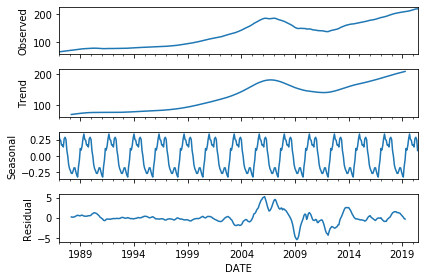

In [202]:
# considering the seasonal factors
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data['CSUSHPISA'],freq=28)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
 
plt.figure(figsize=[15, 7])
decomposition.plot()

In [206]:
# Check Stationarity of seasonal parts
import statsmodels.tsa.api as tsa
result = tsa.adfuller(seasonal)
result
# seaonal parts is sationary

(-14.3479659315504,
 1.0332557285388123e-26,
 17,
 384,
 {'1%': -3.4474946672686824,
  '5%': -2.8690962436986855,
  '10%': -2.570795299750434},
 -1495.4118776977698)

In [213]:
data['CSUSHPISA']

DATE
1987-01-31     63.989
1987-02-28     64.448
1987-03-31     64.761
1987-04-30     65.152
1987-05-31     65.582
1987-06-30     66.087
1987-07-31     66.519
1987-08-31     66.949
1987-09-30     67.343
1987-10-31     67.755
1987-11-30     68.123
1987-12-31     68.523
1988-01-31     68.874
1988-02-29     69.278
1988-03-31     69.656
1988-04-30     69.986
1988-05-31     70.433
1988-06-30     70.895
1988-07-31     71.361
1988-08-31     71.806
1988-09-30     72.247
1988-10-31     72.646
1988-11-30     73.083
1988-12-31     73.473
1989-01-31     73.954
1989-02-28     74.388
1989-03-31     74.786
1989-04-30     75.090
1989-05-31     75.310
1989-06-30     75.483
               ...   
2018-01-31    198.387
2018-02-28    199.353
2018-03-31    200.209
2018-04-30    200.993
2018-05-31    201.680
2018-06-30    202.414
2018-07-31    202.909
2018-08-31    203.723
2018-09-30    204.395
2018-10-31    205.168
2018-11-30    205.671
2018-12-31    206.085
2019-01-31    206.550
2019-02-28    206.983
2019-

We run ADF Test and the result shows that the seasonal series is stationary and then we use a grid search to find the suggested parameters for seasonal_order(1, 0, 0, 12) in  SARIMAX . 

In [215]:
import itertools
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def get_ARIMA_params(data, pdq, m=12):
    p = d = q = range(0, 3)
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in list(itertools.product(p, d, q))]
    score_aic = 1000000.0
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    for param_seasonal in seasonal_pdq:
        mod = SARIMAX(data,order=pdq,
                      seasonal_order=param_seasonal)
        results = mod.fit()
        print(pdq,param_seasonal, results.aic, results.bic)
        #print('order{}*seasonal{} - AIC:{2.f%}-BIC:{}'.format(pdq,param_seasonal, results.aic, results.bic))

        
pdq = [2, 1, 1]
get_ARIMA_params(data['CSUSHPISA'], pdq, m=12)

[2, 1, 1] (0, 0, 0, 12) 34.10371151188647 50.07955722111275
[2, 1, 1] (0, 0, 1, 12) 2.5475995198083297 22.517406656341176
[2, 1, 1] (0, 0, 2, 12) -2.084676310618704 21.879092253220712
[2, 1, 1] (0, 1, 0, 12) 146.52629453789515 162.38061191236895
[2, 1, 1] (0, 1, 1, 12) 43.26522879467666 63.08312551276889
[2, 1, 1] (0, 1, 2, 12) 26.140331378802358 49.921807440513035
[2, 1, 1] (0, 2, 0, 12) 522.6970672359568 538.4260479857488
[2, 1, 1] (0, 2, 1, 12) 196.90513135973885 216.5663572969789
[2, 1, 1] (0, 2, 2, 12) 124.5564470782775 148.14991820296558
[2, 1, 1] (1, 0, 0, 12) -5.019730709623332 14.950076426909515
[2, 1, 1] (1, 0, 1, 12) -5.001708483111429 18.962060080727987
[2, 1, 1] (1, 0, 2, 12) -3.0214581269875964 24.936271864158385
[2, 1, 1] (1, 1, 0, 12) 95.37815684897231 115.19605356706454
[2, 1, 1] (1, 1, 1, 12) 22.51405651469264 46.29553257640332
[2, 1, 1] (1, 1, 2, 12) 23.529331118985198 51.274386524314316
[2, 1, 1] (1, 2, 0, 12) 360.1675265266066 379.8287524638466
[2, 1, 1] (1, 2, 1, 

In [226]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model  = SARIMAX(data['CSUSHPISA'],order=(2,1,1),seasonal_order=(1,0,0,12))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          CSUSHPISA   No. Observations:                  402
Model:             SARIMAX(2, 1, 1)x(1, 0, 0, 12)   Log Likelihood                   7.510
Date:                            Sun, 27 Sep 2020   AIC                             -5.020
Time:                                    17:54:47   BIC                             14.950
Sample:                                01-31-1987   HQIC                             2.888
                                     - 06-30-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0801      0.119      0.671      0.502      -0.154       0.314
ar.L2          0.7994      0.106      7.522      0.000       0.591       1.008
ma.L1          0.8007      0.128      6.273      0.000       0.551       1.051
ar.S.L12       0.3377      0.027     12.386      0.000       0.284       0.391
sigma2         0.0559      0.002     32.821      0.000       0.053       0.059
===================================================================================
Ljung-Box (Q):                       55.88   Jarque-Bera (JB):              2984.93
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):              22.36   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [227]:
resid_SARIMAX = result.resid

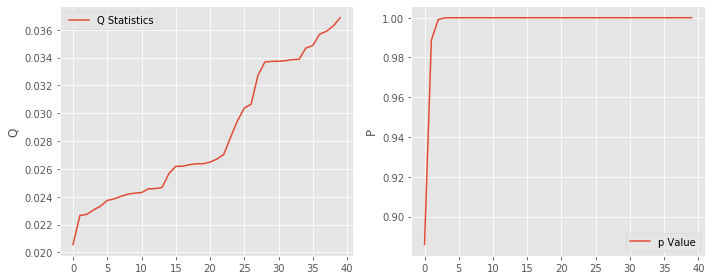

In [228]:
whitenoise_test(resid_SARIMAX)

### 3.3 Conclusion  

Although  both ARIMA(13,1,0)  and  SARIMA(order=(2,1,1), seasonal_order=(1, 0, 0, 12)) can fit the data and with white-noise-like residual, we believe that SARIMAX (order=(2,1,1), seasonal_order=(1, 0, 0, 12)) is a better choice due to less parameters and better performance in AIC and BIC.


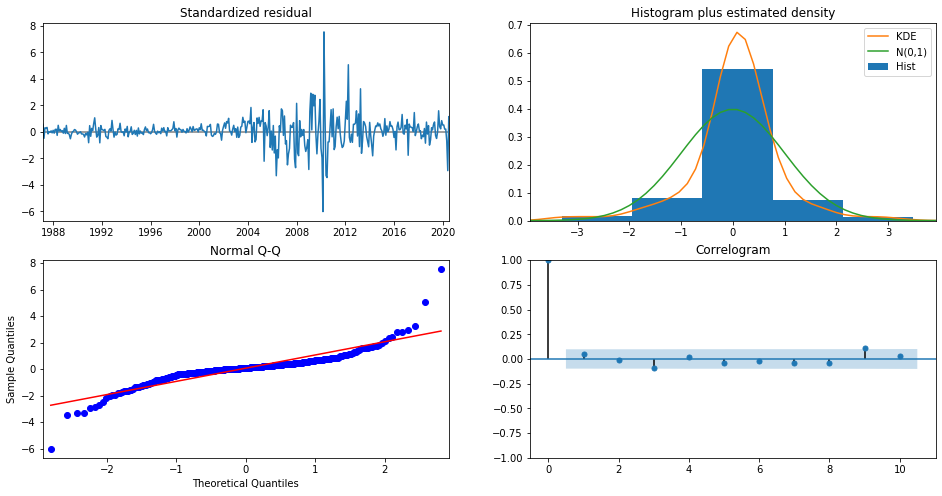

In [229]:
fig_diag = result.plot_diagnostics(figsize=(16,8))

### 4 Forecast

In [244]:
def plot_act_pred(act, pred):
    fig, ax = plt.subplots(figsize=(16,5))
    color1 = 'red'
    color2 = 'blue'
    ax.plot(act.index, act, label='Actual', color=color1)
    ax.plot(pred.index, pred, label='Predicted', color=color2)
    plt.legend()
    plt.show()    

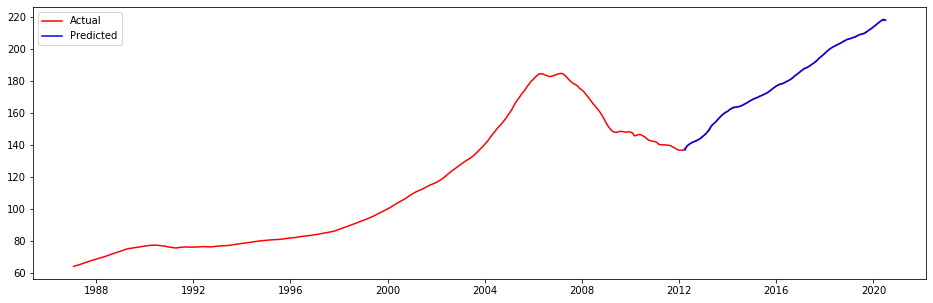

In [247]:
#plot actual Case-Shiller Index diff 
forecast = result.predict(tys="level", start=-100)
plot_act_pred(data['CSUSHPISA'], forecast)